In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import shutil

In [2]:
path = 'lego/star-wars - images/'
names = ['YODA','LUKE SKYWALKER','R2-D2','MACE WINDU','GENERAL GRIEVOUS']

tf.random.set_seed(42)

### Create train-test folder

In [3]:
if not os.path.isdir(path + 'train/'):
    for name in names :
        os.makedirs(path + 'train/' + name)
        os.makedirs(path + 'val/' + name)
        os.makedirs(path + 'test/' + name)

In [4]:
# Moce the image files
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
try :
    for folder_idx, folder in enumerate(orig_folders):
        files = os.listdir(path + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = path + folder + file
        if idx < n_train:
            shutil.move(file_name, path + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, path + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, path + "test/" + names[folder_idx])
except :
    pass


In [5]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#    rotation_range=20,
#    horizontal_flip=True,
#    width_shift_range=0.2, height_shift_range=0.2,
#    shear_range=0.2, zoom_range=0.2)

valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars - images/train',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars - images/val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars - images/test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [6]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[1. 4. 1. 1.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


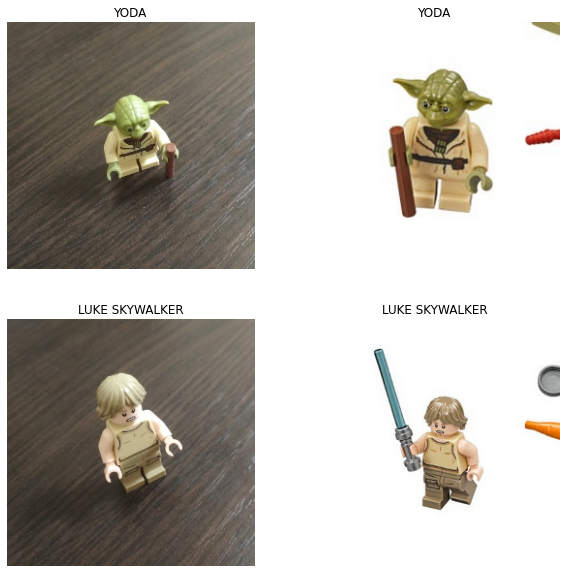

In [7]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(batch[0][i])
        plt.axis('off')
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.title(lbl)
    plt.show()

show(test_batch)

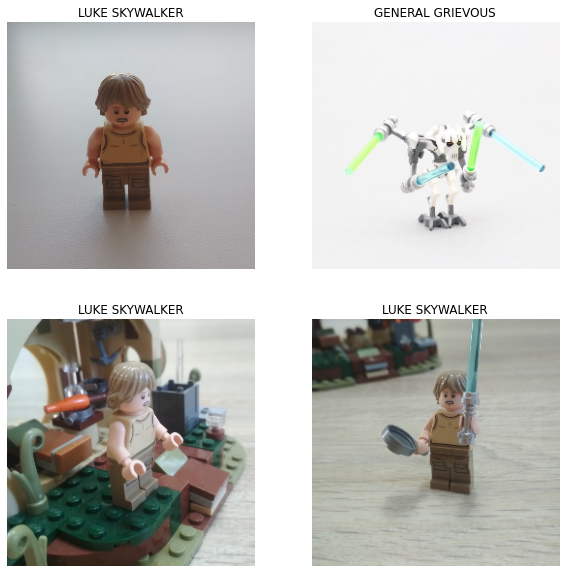

In [8]:
show(train_batch)

### CNN-Model

**EarlyStopping** callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.
The EarlyStopping callback is configured when instantiated via arguments.
The “monitor” allows you to specify the performance measure to monitor in order to end training. Recall from the previous section that the calculation of measures on the validation dataset will have the ‘val_‘ prefix, such as ‘val_loss‘ for the loss on the validation dataset.
* 5 patience > if the training loss has not improved for 5 epochs in a roll:

In [9]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5,activation='softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1)
model_1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])


history = model_1.fit_generator(train_batches, validation_data=val_batches,callbacks=[early_stopping], epochs=30, verbose=1)

Epoch 1/30


C:\Users\alant\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\alant\AppData\Local\Temp/ipykernel_12116/2616771189.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_1.fit_generator(train_batches, validation_data=val_batches,callbacks=[early_stopping], epochs=30, verbose=1)


10/10 [==============================] - 3s 236ms/step - loss: 5.2004 - accuracy: 0.1622 - val_loss: 1.5845 - val_accuracy: 0.3750
Epoch 2/30
10/10 [==============================] - 2s 212ms/step - loss: 1.5813 - accuracy: 0.2703 - val_loss: 1.8498 - val_accuracy: 0.3125
Epoch 3/30
10/10 [==============================] - 2s 214ms/step - loss: 1.6110 - accuracy: 0.4324 - val_loss: 2.4594 - val_accuracy: 0.2500
Epoch 4/30
10/10 [==============================] - 2s 222ms/step - loss: 1.4210 - accuracy: 0.4324 - val_loss: 1.5228 - val_accuracy: 0.2500
Epoch 5/30
10/10 [==============================] - 2s 217ms/step - loss: 0.9538 - accuracy: 0.6216 - val_loss: 1.5020 - val_accuracy: 0.3750
Epoch 6/30
10/10 [==============================] - 2s 218ms/step - loss: 0.7416 - accuracy: 0.7568 - val_loss: 1.9973 - val_accuracy: 0.4375
Epoch 7/30
10/10 [==============================] - 2s 207ms/step - loss: 0.3953 - accuracy: 0.8378 - val_loss: 2.1423 - val_accuracy: 0.5000
Epoch 8/30
10/10 

In [10]:
model_1.evaluate(test_batches)

3/3 [==============================] - 0s 29ms/step - loss: 0.7246 - accuracy: 0.8000


[0.7246047258377075, 0.800000011920929]

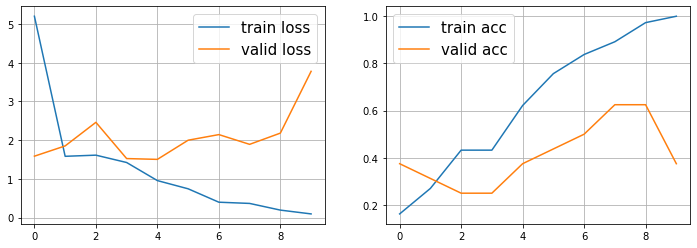

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

> overfitting with Train_batches because with 100% acc but in val_accuracy is just 37%

In [12]:
predictions = model_1.predict(test_batches)
pred_lables = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(pred_lables[:4])

[0. 0. 1. 1.]
[0 0 1 0]


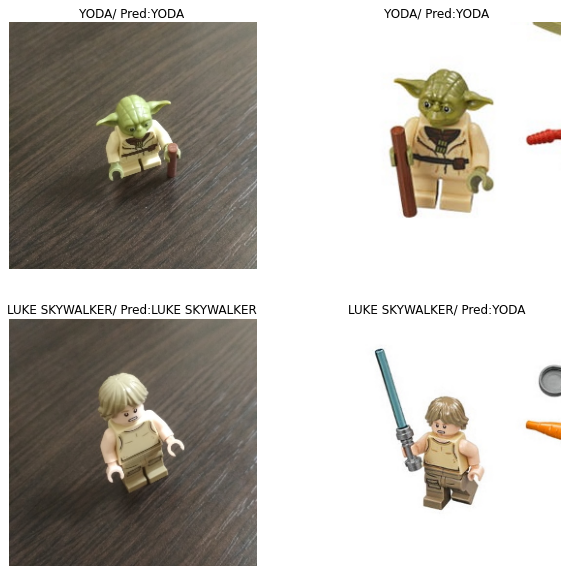

In [13]:
show(test_batches[0], pred_lables[:4])

> that's why it predict with low performance

### Transfer learning

when elements of a pre-trained model are reused in a new machine learning model. If the two models are developed to perform similar tasks, then generalised knowledge can be shared between them

In [14]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

<class 'keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (Ma

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date

### Preprocessing same as VGG16

In [15]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [16]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars - images/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars - images/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars - images/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [17]:
model_2 = tf.keras.Sequential()
for layer in vgg_model.layers[:-1] : # cut the last layer of vgg out
    model_2.add(layer)

In [18]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [19]:
# don't want to train it again
for layer in model_2.layers:
    layer.trainable = False

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [20]:
# then add output layer for perdict 5 classes of image
model_2.add(tf.keras.layers.Dense(5,activation='softmax'))

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1)
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])


history_2 = model_2.fit_generator(train_batches, validation_data=val_batches,callbacks=[early_stopping], epochs=30, verbose=1)

Epoch 1/30


C:\Users\alant\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\alant\AppData\Local\Temp/ipykernel_12116/694259420.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model_2.fit_generator(train_batches, validation_data=val_batches,callbacks=[early_stopping], epochs=30, verbose=1)


10/10 [==============================] - 7s 665ms/step - loss: 2.3308 - accuracy: 0.4054 - val_loss: 0.7970 - val_accuracy: 0.6250
Epoch 2/30
10/10 [==============================] - 6s 601ms/step - loss: 0.7815 - accuracy: 0.7568 - val_loss: 0.2021 - val_accuracy: 0.8750
Epoch 3/30
10/10 [==============================] - 6s 627ms/step - loss: 0.0974 - accuracy: 0.9730 - val_loss: 0.3360 - val_accuracy: 0.8750
Epoch 4/30
10/10 [==============================] - 7s 760ms/step - loss: 0.0476 - accuracy: 0.9730 - val_loss: 0.1470 - val_accuracy: 0.9375
Epoch 5/30
10/10 [==============================] - 8s 822ms/step - loss: 0.0235 - accuracy: 0.9730 - val_loss: 0.1099 - val_accuracy: 0.9375
Epoch 6/30
10/10 [==============================] - 7s 765ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 0.9375
Epoch 7/30
10/10 [==============================] - 8s 776ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1350 - val_accuracy: 0.9375
Epoch 8/30
10/10 

In [22]:
model_2.evaluate(test_batches)

3/3 [==============================] - 1s 377ms/step - loss: 0.2059 - accuracy: 0.9000


[0.2058548480272293, 0.8999999761581421]

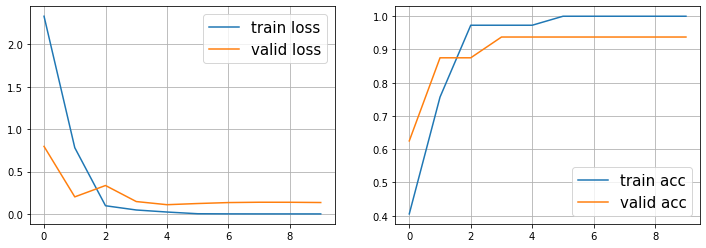

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='train loss')
plt.plot(history_2.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='train acc')
plt.plot(history_2.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

> it's ok with 93% acc with testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


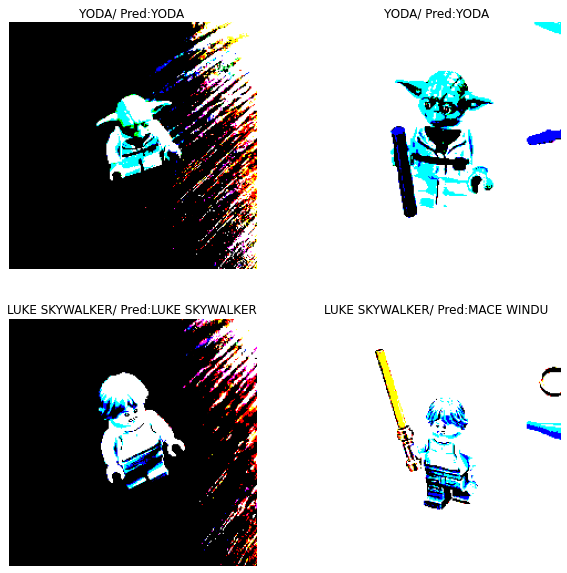

In [32]:
predictions = model_2.predict(test_batches)
pred_lables = np.argmax(predictions, axis=1)

show(test_batches[0], pred_lables[:4])